# Clustering (Agrupamento) - Butina

*Clustering*, ou Agrupamento, é uma técnica usada para agrupar objetos similares em grupos. Este Notebook é uma continuação do [Notebook Clustering (Agrupamento)](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Clustering%20(Agrupamento).ipynb), no qual os métodos de agrupamento **K-means** e **K-medoids** são discutidos. 

Diferentemente dos métodos apresentados, o algoritmo [**Butina**](https://pubs.acs.org/doi/abs/10.1021/ci9803381), desenvolvido especificamente para agrupamento de *fingerprints* moleculares, não nos permite escolher o número final de *clusters*. O que devemos fazer é selecionar de antemão um **valor de corte** (também chamado de *cutoff*, *threshold*) para a distância entre os *fingerprints*. 

Por exemplo, se usarmos os valores de (1 - índice de Tanimoto) para calcular as distâncias entre os *fingerprints* e escolhermos o valor 0.8 como valor de corte, ao final do agrupamento cada *cluster* conterá estruturas cujas distâncias entre si são menores que 0.8 (a menor distância possível é 0). Logo, quanto menor o valor de corte, mais *clusters* teremos no final, e vice-versa.

Neste Notebook, vamos explorar o método Butina, disponível no RDKit, para agrupar algumas estruturas de antibióticos de acordo com a similaridade de seus *fingerprints* moleculares. Como o *dataset* também possui uma coluna com os nomes das classes a que pertencem os antibióticos, será possível verificar se os grupos formados pelo método Butina se aproximam às classes esperadas.

Fontes consultadas: 
- https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html
- https://www.rdkit.org/docs/source/rdkit.ML.Cluster.Butina.html

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, rdFingerprintGenerator
from rdkit.ML.Cluster import Butina

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
df = pd.read_csv('../datasets/antibiotics_SMILES.csv')
df.head()

,name,class,SMILES
0,Amikacin,aminoglycosides,NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]...
1,Gentamicin,aminoglycosides,CNC(C)C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC...
2,Kanamycin,aminoglycosides,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...
3,Neomycin,aminoglycosides,NC[C@@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@...
4,Netilmicin,aminoglycosides,CCN[C@@H]1C[C@H](N)[C@@H](O[C@H]2OC(CN)=CC[C@H...


In [4]:
df.shape

(146, 3)

In [5]:
# Transformar SMILES em RDKit Mol
df["rdkit_mol"] = df["SMILES"].apply(Chem.MolFromSmiles)

In [6]:
# Gerar fingerprints Morgan
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024) 
fingerprints = [fpgen.GetFingerprint(mol) for mol in df["rdkit_mol"]]

In [7]:
print("Número de estruturas: ", len(fingerprints))
print("Tamanho dos fingerprints:", len(fingerprints[0]))

Número de estruturas:  146
Tamanho dos fingerprints: 1024


Funções para calcular a matriz de distâncias e para realizar o agrupamento

In [8]:
def tanimoto_distance_matrix(fp_list):
    """Calcular a matriz de distâncias para a lista de fingerprints"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        # Comparar o fingerprint atual com todos os anteriores na lista
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Como precisamos de uma matriz de distâncias, e o índice de Tanimoto mede similaridade,
        # calculamos 1-x para cada elemento na matriz de similaridade
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix


def cluster_fingerprints(fingerprints, cutoff):
    """Realizar o agrupamento dos fingerprints
    Parâmetros:
        fingerprints: lista de fingerprints
        cutoff: threshold (limiar) de dissimilaridade para o agrupamento
    """
    # Calculando a matriz de distâncias
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Agrupando os dados usando o algoritmo Butina
    # Note o uso de isDistData=True pois pré-calculamos a matriz de distâncias
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

Relembrando: Quanto maior o valor de *cutoff* (o valor de corte), mais moléculas são consideradas semelhantes entre si e, portanto, o agrupamento fornecerá menos grupos. Se o valor de corte for muito pequeno, terminamos com muitos grupos pequenos e vários “singletons” ("grupos" contendo apenas uma molécula).

In [9]:
# Vejamos quantas classes temos no nosso dataset original
len(df["class"].unique())

22

Vamos explorar alguns valores de *cutoff* e verificar o efeito np número de *clusters* obtidos

In [10]:
# Executando o agrupamento com um valor baixo de cutoff
clusters = cluster_fingerprints(fingerprints, cutoff=0.1)

print("Total de clusters: ", len(clusters))

Total de clusters:  141


In [11]:
# Executando o agrupamento com um valor alto de cutoff
clusters = cluster_fingerprints(fingerprints, cutoff=0.9)

print("Total de clusters: ", len(clusters))

Total de clusters:  6


In [12]:
# Executando o agrupamento com um valor intermediário de cutoff
clusters = cluster_fingerprints(fingerprints, cutoff=0.8)

print("Total de clusters: ", len(clusters))

Total de clusters:  23


Parece que finalmente escolhemos um valor de corte razoável. Vamos visualizar o tamanho dos *clusters* obtidos e comparar com as classes originais. 

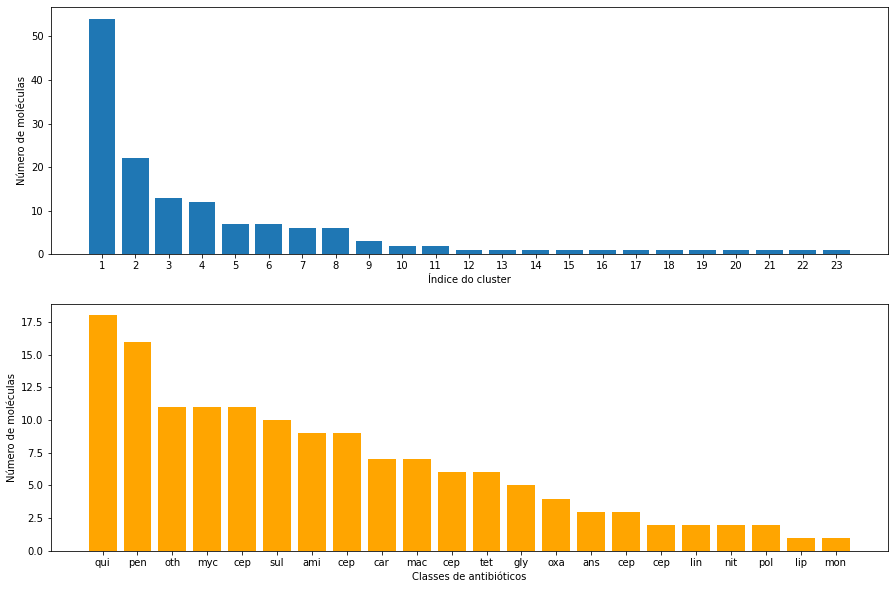

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(15, 10))

ax1.set_xlabel("Índice do cluster")
ax1.set_ylabel("Número de moléculas")
ax1.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
ax1.set_xticks(np.arange(1, len(clusters) + 1, 1))

ax2.set_xlabel("Classes de antibióticos")
ax2.set_ylabel("Número de moléculas")
ax2.bar(range(1, len(df["class"].unique()) + 1), df["class"].value_counts().to_list(), lw=5, color='orange')
ax2.set_xticks(np.arange(1, len(df["class"].unique()) + 1, 1))
ax2.set_xticklabels([item[:3] for item in df["class"].value_counts().index.to_list()])

plt.show()

Nota-se algo estranho: nosso agrupamento forneceu um grupo com mais de 50 estruturas, mas não há nenhuma classe desse tamanho. Também terminamos com vários grupos muito pequenos. 

Vamos ver o que aconteceu, mostrando as classes correspondentes às estruturas do maior *cluster*:

In [14]:
print(f"Cluster 1:")
print(df.iloc[list(clusters[0])]["class"].value_counts().to_string())

Cluster 1:
penicillins        16
cephalosporins3    11
cephalosporins2     9
cephalosporins1     6
carbapenem          6
cephalosporins4     3
cephalosporins5     2
monobactams         1


Nota-se que diversas classes foram agrupadas no mesmo *cluster*. Vamos investigar os grupos menores, talvez alguma informação útil possa ser extraída.

In [15]:
for i in range(8,len(clusters)):
    print(f"Cluster {i+1}:", df.iloc[list(clusters[i])]["class"].value_counts().to_string())

Cluster 9: others    3
Cluster 10: mycobacteria    2
Cluster 11: nitrofurans    2
Cluster 12: carbapenem    1
Cluster 13: glycopeptides    1
Cluster 14: others    1
Cluster 15: others    1
Cluster 16: others    1
Cluster 17: aminoglycosides    1
Cluster 18: others    1
Cluster 19: others    1
Cluster 20: others    1
Cluster 21: mycobacteria    1
Cluster 22: mycobacteria    1
Cluster 23: mycobacteria    1


Parece que diversos antibióticos das classes "mycobacteria" e "others" estão sendo colocados em grupos isolados. Isso é uma indicação de que esses compostos são muito diferentes de todos os outros do nosso conjunto de dados, e estão prejudicando nossa análise. 

Quando eu montei esse *dataset*, percebi que as estruturas presentes nessas "classes" não têm muita semelhança entre si, diferente das outras classes de antibióticos, que em geral compartilham um mesmo motivo estrutural.

Vamos repetir a análise removendo essas duas classes do conjunto de dados:

In [16]:
df_clean = df[~df['class'].isin(["mycobacteria", "others"])]
df_clean.shape

(124, 4)

In [17]:
# Gerar fingerprints Morgan
fingerprints = [fpgen.GetFingerprint(mol) for mol in df_clean["rdkit_mol"]]

# Executando o agrupamento para o novo conjunto de dados
clusters = cluster_fingerprints(fingerprints, cutoff=0.8)
print("Total de clusters: ", len(clusters))

Total de clusters:  12


Ao remover os *outliers*, o mesmo valor de corte acaba gerando muito menos *clusters*. Podemos tentar nos aproximar do número de classes diminuindo o valor de *cutoff*.

In [18]:
# Vejamos quantas classes temos no nosso dataset limpo
len(df_clean["class"].unique())

20

In [19]:
clusters = cluster_fingerprints(fingerprints, cutoff=0.75)
print("Total de clusters: ", len(clusters))

Total de clusters:  18


Vamos ver se dessa vez os *clusters* se aproximam melhor das classes:

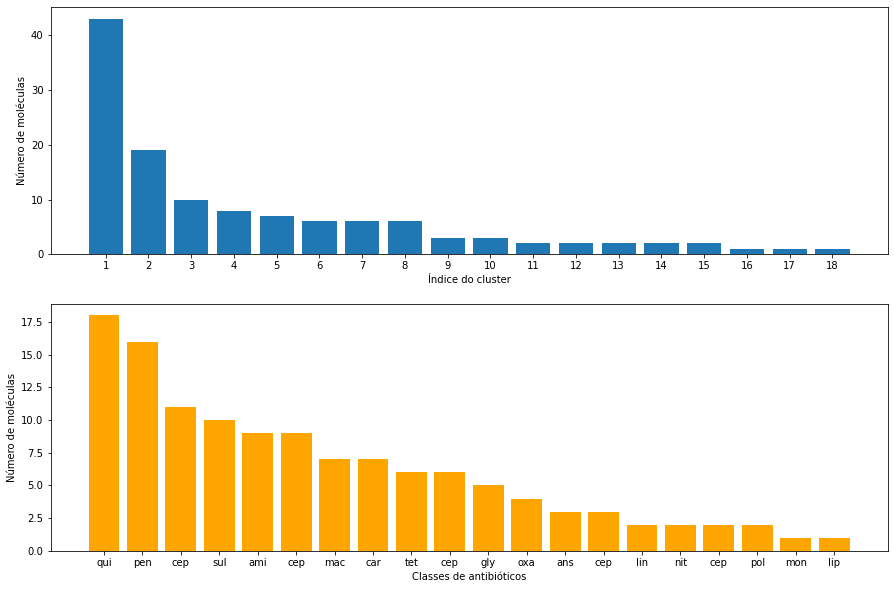

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(15, 10))

ax1.set_xlabel("Índice do cluster")
ax1.set_ylabel("Número de moléculas")
ax1.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
ax1.set_xticks(np.arange(1, len(clusters) + 1, 1))

ax2.set_xlabel("Classes de antibióticos")
ax2.set_ylabel("Número de moléculas")
ax2.bar(range(1, len(df_clean["class"].unique()) + 1), df_clean["class"].value_counts().to_list(), lw=5, color='orange')
ax2.set_xticks(np.arange(1, len(df_clean["class"].unique()) + 1, 1))
ax2.set_xticklabels([item[:3] for item in df_clean["class"].value_counts().index.to_list()])

plt.show()

Ainda é possível observar um *cluster* grande, com mais de 40 compostos. Vamos visualizá-lo:

In [21]:
print(f"Cluster 1:")
print(df_clean.iloc[list(clusters[0])]["class"].value_counts().to_string())

Cluster 1:
penicillins        15
cephalosporins3    10
cephalosporins2     7
cephalosporins1     6
cephalosporins4     3
cephalosporins5     2


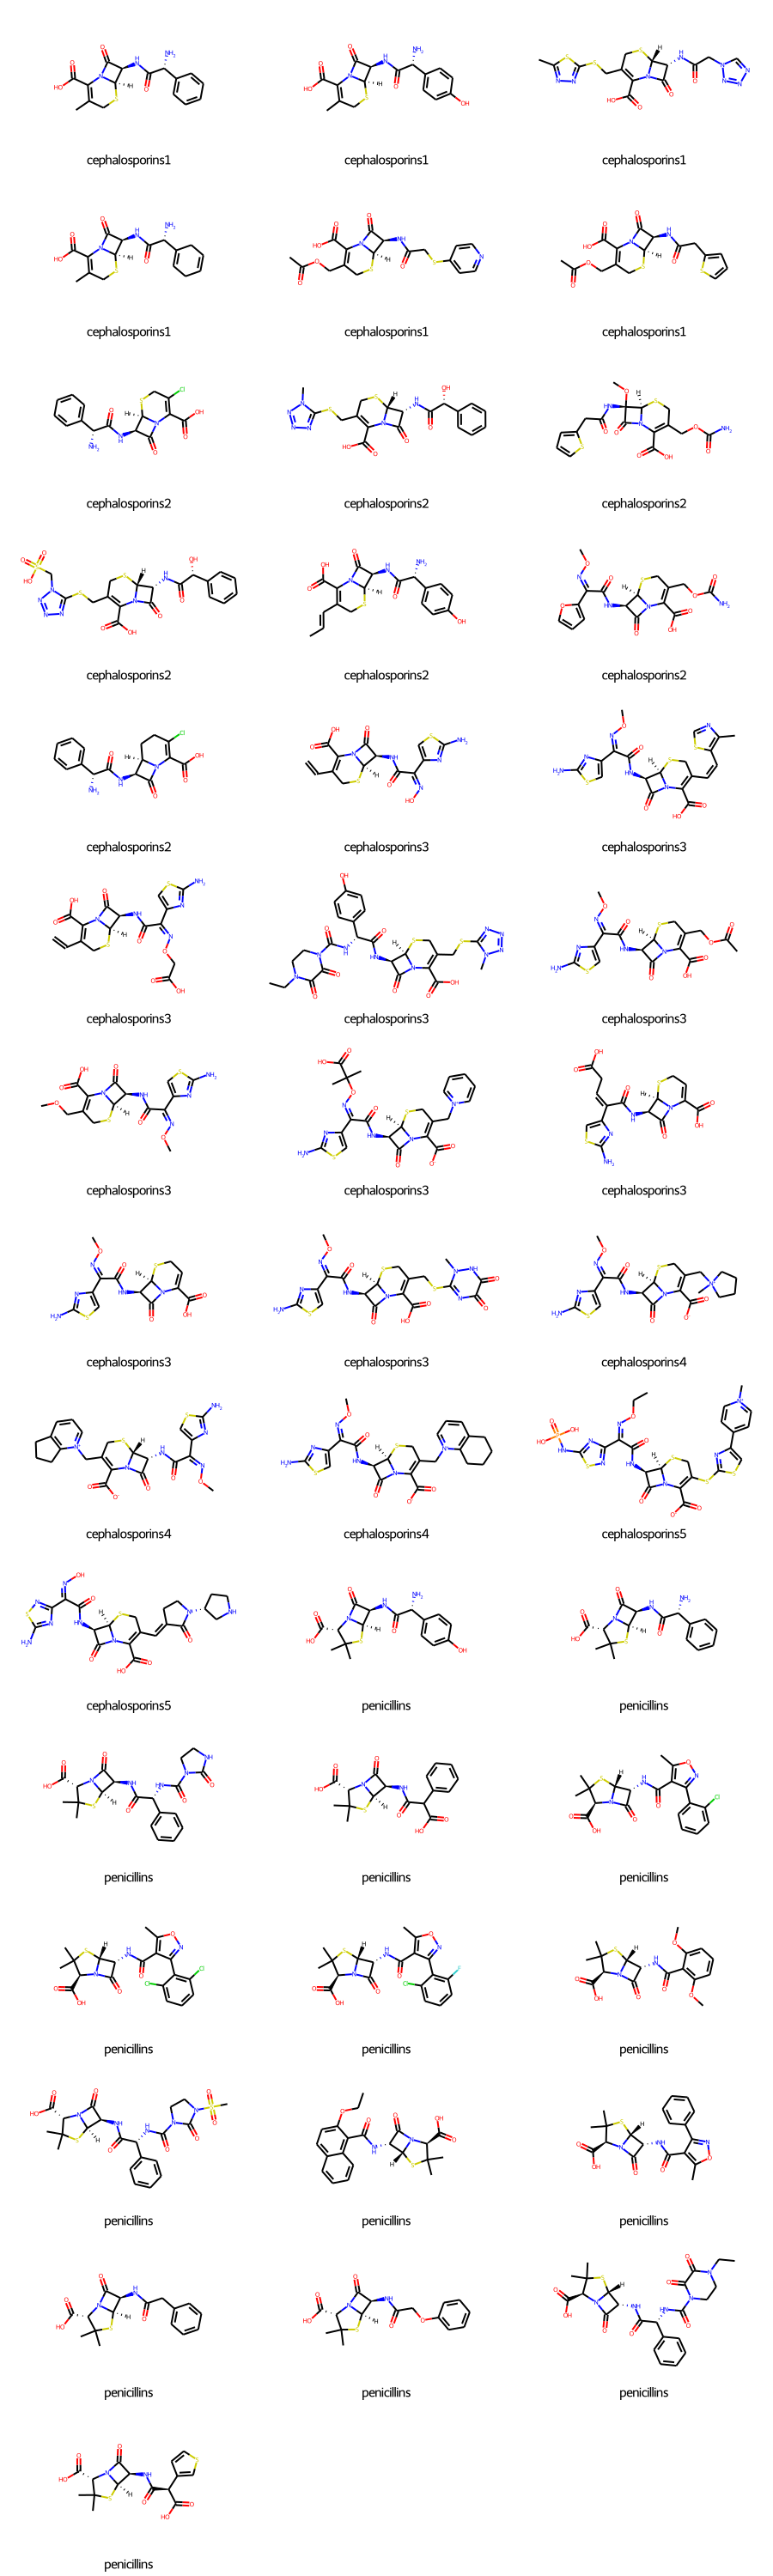

In [22]:
Draw.MolsToGridImage(df_clean.iloc[list(clusters[0])]["rdkit_mol"], subImgSize=(300,200),
                     legends=df_clean.iloc[list(clusters[0])]["class"].to_list())

O resultado não é de espantar: como os compostos das classes "penicilinas" e das cinco gerações de "cefalosporinas" são similares entre si, o algoritmo não é capaz de diferenciá-los, e acaba juntando todos no mesmo *cluster*. De fato, essas classes pertencem a uma ampla classe de antibióticos: os [antibióticos betalactâmicos](https://pt.wikipedia.org/wiki/Antibi%C3%B3tico_betalact%C3%A2mico).

No código abaixo, você pode modificar o valor de `cluster_number` para visualizar os compostos agrupados nos outros *clusters*. Você pode verificar que a maioria dos *clusters* contém antibióticos da mesma classe, mostrando que nosso método de agrupamento foi bem sucedido em identificar as características estruturais dos antibióticos.

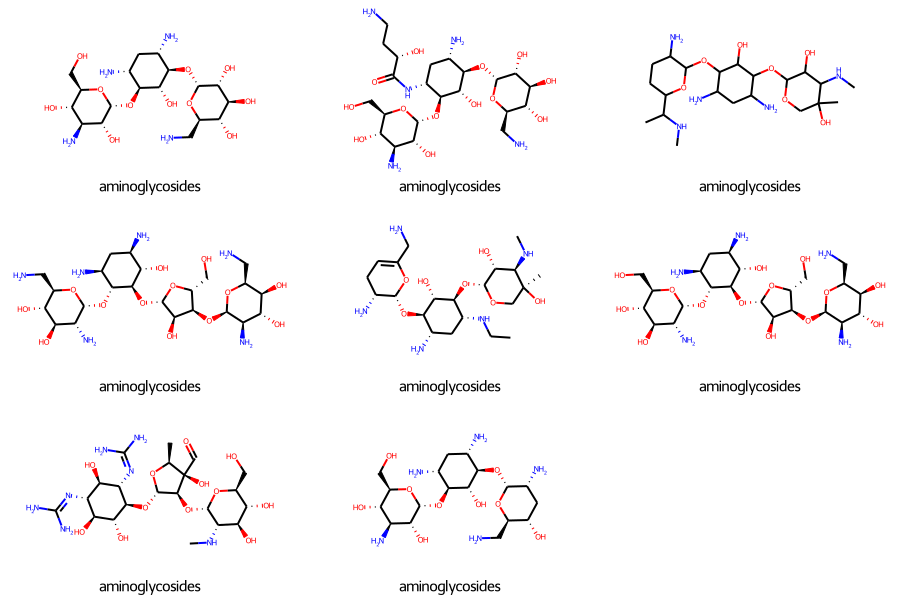

In [23]:
# Modifique o número abaixo com um valor entre 1 e 18

cluster_number = 4

Draw.MolsToGridImage(df_clean.iloc[list(clusters[cluster_number-1])]["rdkit_mol"], subImgSize=(300,200),
                     legends=df_clean.iloc[list(clusters[cluster_number-1])]["class"].to_list())